In [ ]:
# 1. Installing Necessary Libraries
!pip install numpy pandas matplotlib seaborn scikit-learn opencv-python torch torchvision tqdm efficientnet-pytorch

In [1]:
# 2. Importing the Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

In [2]:
# 3. Loading the Dataset
data_dir = 'C:/Users/rishi/Desktop/JHU/Critical Infrastructure Protection/Major Project/Data Sets/Sonar/Test_Malicious/'
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
print(f"Classes: {class_names}")

Classes: ['Malicious', 'Non-Malicious']


In [3]:
# 4. Transforming the Dataset to Be Passed Into the Model
random_seed = 420  # Custom random seed for reproducibility
torch.manual_seed(random_seed)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# 5. Defining Model Initialization Function
def initialize_model(model_name, num_classes, weights=None):
    if model_name == "resnet18":
        model = models.resnet18(weights=weights)
        model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet-b0":
        model = EfficientNet.from_name("efficientnet-b0")
        model._fc = torch.nn.Linear(model._fc.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} not recognized. Use 'resnet18', 'vgg16', or 'efficientnet-b0'.")
    return model

In [5]:
# 6. Setting Up Models and Parameter Grid
num_classes = len(class_names)
models_to_test = ["resnet18", "efficientnet-b0"]
weights_to_use = {
    "resnet18": models.ResNet18_Weights.IMAGENET1K_V1
}  # EfficientNet doesn't have explicit weights in torchvision.

# Define parameter grid for hyperparameter tuning
parameter_grid = {
    "learning_rate": [0.0001, 0.0005],
    "batch_size": [32, 64],
    "epochs": [10, 15, 20]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

models_dict = {}

for model_name in models_to_test:
    weights = weights_to_use.get(model_name, None)
    models_dict[model_name] = initialize_model(model_name, num_classes, weights).to(device)

cuda


In [7]:
# Dictionary to store results for all tested models and hyperparameter combinations
results = {}

# Initialize variables to track the best model
best_accuracy = 0.0
best_precision = 0.0
best_model = None
best_model_name = None
best_hyperparams = None

# Training and testing loop for all models and hyperparameters
for model_name, model in models_dict.items():
    print(f"\nTraining and testing model: {model_name}")
    
    # Iterate through the parameter grid
    for lr in parameter_grid["learning_rate"]:
        for bs in parameter_grid["batch_size"]:
            print(f"\nTesting {model_name} with Learning Rate: {lr}, Batch Size: {bs}")

            # Define optimizer and loss function
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
            criterion = torch.nn.CrossEntropyLoss()

            # Reinitialize data loaders for the current batch size
            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

            # Training loop
            for epoch in range(parameter_grid["epochs"][0]):  # Default to 10 epochs
                model.train()
                running_loss = 0.0
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                print(f"Model: {model_name}, Epoch: {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")

            # Testing loop
            model.eval()
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='macro')
            conf_matrix = confusion_matrix(y_true, y_pred)

            # Print metrics and confusion matrix
            print(f"Accuracy: {accuracy * 100:.2f}%, Precision: {precision * 100:.2f}%")
            print("Confusion Matrix:")
            print(conf_matrix)

            # Update results dictionary
            results[(model_name, lr, bs)] = {
                "accuracy": accuracy * 100,
                "precision": precision * 100,
                "confusion_matrix": conf_matrix,
                "loss": running_loss / len(train_loader)
            }

            # Update the best model based on accuracy and precision
            if accuracy > best_accuracy or (accuracy == best_accuracy and precision > best_precision):
                best_accuracy = accuracy
                best_precision = precision
                best_model = model
                best_model_name = model_name
                best_hyperparams = (lr, bs)
                
# Save the best model
if best_model is not None:
    torch.save(best_model, f"{best_model_name}_complete.pth")
    print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy * 100:.2f}% saved as '{best_model_name}_best_model.pth'")
    print(f"Best Hyperparameters: Learning Rate = {best_hyperparams[0]}, Batch Size = {best_hyperparams[1]}")
    torch.save(best_model.state_dict(), f"{best_model_name}_state_dict.pth")
    print("state_dict Saved!")


Training and testing model: resnet18

Testing resnet18 with Learning Rate: 0.0001, Batch Size: 32
Model: resnet18, Epoch: 1, Loss: 0.0388
Model: resnet18, Epoch: 2, Loss: 0.0019
Model: resnet18, Epoch: 3, Loss: 0.0012
Model: resnet18, Epoch: 4, Loss: 0.0047
Model: resnet18, Epoch: 5, Loss: 0.0082
Model: resnet18, Epoch: 6, Loss: 0.0014
Model: resnet18, Epoch: 7, Loss: 0.0003
Model: resnet18, Epoch: 8, Loss: 0.0085
Model: resnet18, Epoch: 9, Loss: 0.0007
Model: resnet18, Epoch: 10, Loss: 0.0002
Accuracy: 99.88%, Precision: 99.88%
Confusion Matrix:
[[401   1]
 [  0 402]]

Testing resnet18 with Learning Rate: 0.0001, Batch Size: 64
Model: resnet18, Epoch: 1, Loss: 0.0148
Model: resnet18, Epoch: 2, Loss: 0.0005
Model: resnet18, Epoch: 3, Loss: 0.0001
Model: resnet18, Epoch: 4, Loss: 0.0000
Model: resnet18, Epoch: 5, Loss: 0.0000
Model: resnet18, Epoch: 6, Loss: 0.0000
Model: resnet18, Epoch: 7, Loss: 0.0000
Model: resnet18, Epoch: 8, Loss: 0.0000
Model: resnet18, Epoch: 9, Loss: 0.0000
Mo

In [8]:
# Compare results for all models and hyperparameter combinations
print("\nSummary of Results:")
for (model_name, lr, bs), metrics in results.items():
    print(f"\nModel: {model_name}, Learning Rate: {lr}, Batch Size: {bs}")
    print(f"Accuracy: {metrics['accuracy']:.2f}%, Precision: {metrics['precision']:.2f}%")
    print("Confusion Matrix:")
    print(metrics['confusion_matrix'])
    print(f"Training Loss: {metrics['loss']:.4f}")


Summary of Results:

Model: resnet18, Learning Rate: 0.0001, Batch Size: 32
Accuracy: 99.88%, Precision: 99.88%
Confusion Matrix:
[[401   1]
 [  0 402]]
Training Loss: 0.0002

Model: resnet18, Learning Rate: 0.0001, Batch Size: 64
Accuracy: 99.88%, Precision: 99.88%
Confusion Matrix:
[[402   0]
 [  1 401]]
Training Loss: 0.0000

Model: resnet18, Learning Rate: 0.0005, Batch Size: 32
Accuracy: 99.63%, Precision: 99.63%
Confusion Matrix:
[[402   0]
 [  3 399]]
Training Loss: 0.0094

Model: resnet18, Learning Rate: 0.0005, Batch Size: 64
Accuracy: 99.38%, Precision: 99.38%
Confusion Matrix:
[[399   3]
 [  2 400]]
Training Loss: 0.0188

Model: efficientnet-b0, Learning Rate: 0.0001, Batch Size: 32
Accuracy: 97.39%, Precision: 97.52%
Confusion Matrix:
[[381  21]
 [  0 402]]
Training Loss: 0.0216

Model: efficientnet-b0, Learning Rate: 0.0001, Batch Size: 64
Accuracy: 98.38%, Precision: 98.39%
Confusion Matrix:
[[394   8]
 [  5 397]]
Training Loss: 0.0101

Model: efficientnet-b0, Learning R

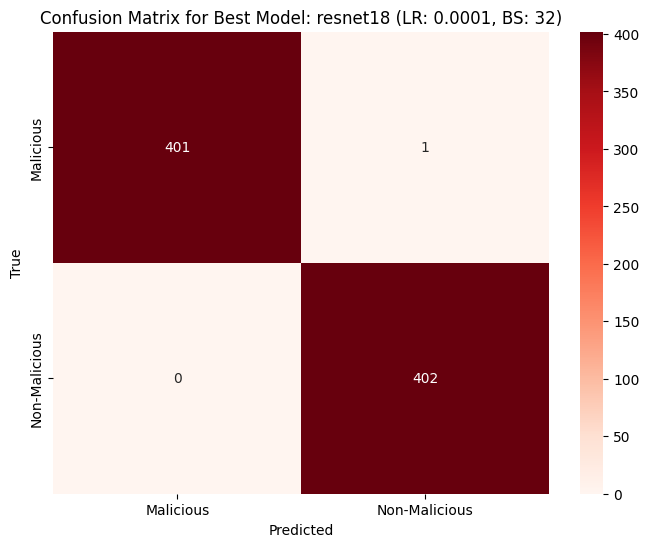

In [9]:
# Identify the best model based on accuracy and precision
best_model_params = max(
    results, 
    key=lambda x: (results[x]["accuracy"], results[x]["precision"])  # Accuracy first, precision as tiebreaker
)
best_model_name, best_lr, best_bs = best_model_params
best_conf_matrix = results[best_model_params]["confusion_matrix"]

# Plot the confusion matrix for the best model
plt.figure(figsize=(8, 6))
sns.heatmap(
    best_conf_matrix, annot=True, fmt='d', cmap='Reds', 
    xticklabels=class_names, yticklabels=class_names
)
plt.title(f'Confusion Matrix for Best Model: {best_model_name} (LR: {best_lr}, BS: {best_bs})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
plt.close()
